In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from stingray import Lightcurve
%matplotlib notebook

In [7]:
filename = './data/NGC_3031_I_MIPS24_bgm2012.fits'
data = fits.open(filename)
image_data = data[0].data
# type(image_data)
image_data.shape

(2040, 1080)

In [5]:
data.info()

Filename: ./data/NGC_3031_I_MIPS24_bgm2012.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   (1080, 2040)   float32   


<IPython.core.display.Javascript object>


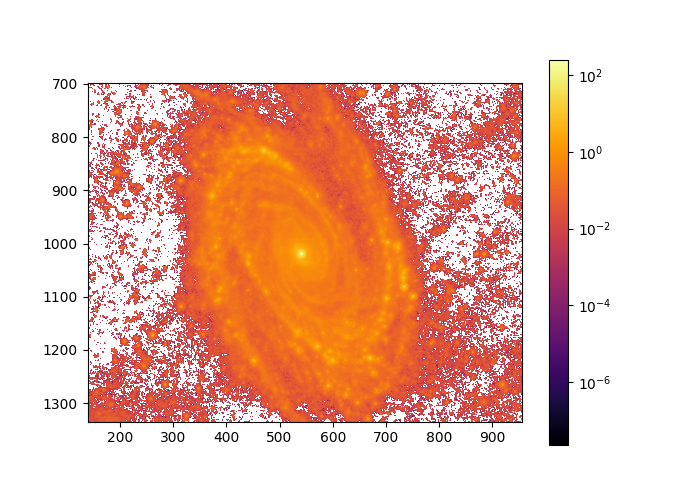

In [10]:
plt.figure(figsize=(7,5))
cmap = 'inferno'
# plt.imshow(image_data)
plt.imshow(image_data, norm=mpl.colors.LogNorm(), cmap=cmap)
plt.colorbar()
# plt.ylim(500, 1500)
plt.show()

In [11]:
filename = './data/nu30101055002A01_cl.evt.gz'
data = fits.open(filename)

In [16]:
data.info()

Filename: ./data/nu30101055002A01_cl.evt.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  EVENTS        1 BinTableHDU    461   1533169R x 39C   [1D, 1D, 1J, 1J, 1J, 9I, 9I, 1D, 9X, 1B, 1B, 1B, 1B, 1B, 1B, 1B, 1B, 1B, 1B, 1B, 16X, 8X, 8X, 9I, 9E, 9E, 9E, 1I, 9B, 9E, 1J, 1E, 1J, 1I, 1I, 1I, 1I, 1I, 1I]   
  2  GTI           1 BinTableHDU     91   255R x 2C   [1D, 1D]   
  3  BADPIX        1 BinTableHDU    116   13R x 5C   [1B, 1B, 1D, 1D, 16X]   
  4  BADPIX        2 BinTableHDU    116   32R x 5C   [1B, 1B, 1D, 1D, 16X]   
  5  BADPIX        3 BinTableHDU    116   32R x 5C   [1B, 1B, 1D, 1D, 16X]   
  6  BADPIX        4 BinTableHDU    116   56R x 5C   [1B, 1B, 1D, 1D, 16X]   


In [20]:
data[1].data['TIME']

array([1.86603256e+08, 1.86603256e+08, 1.86603256e+08, ...,
       1.86642000e+08, 1.86642000e+08, 1.86642000e+08])

In [23]:
x = data[1].data['X']
y = data[1].data['Y']
grade = data[1].data['GRADE']
pi = data[1].data['PI'] # Pulse Invariant
t = data[1].data['TIME']

_filter = np.where((grade>=0)*(grade<=26)*(pi>=35)*(pi<=1935)) 

x, y, t = x[_filter], y[_filter], t[_filter]

<IPython.core.display.Javascript object>


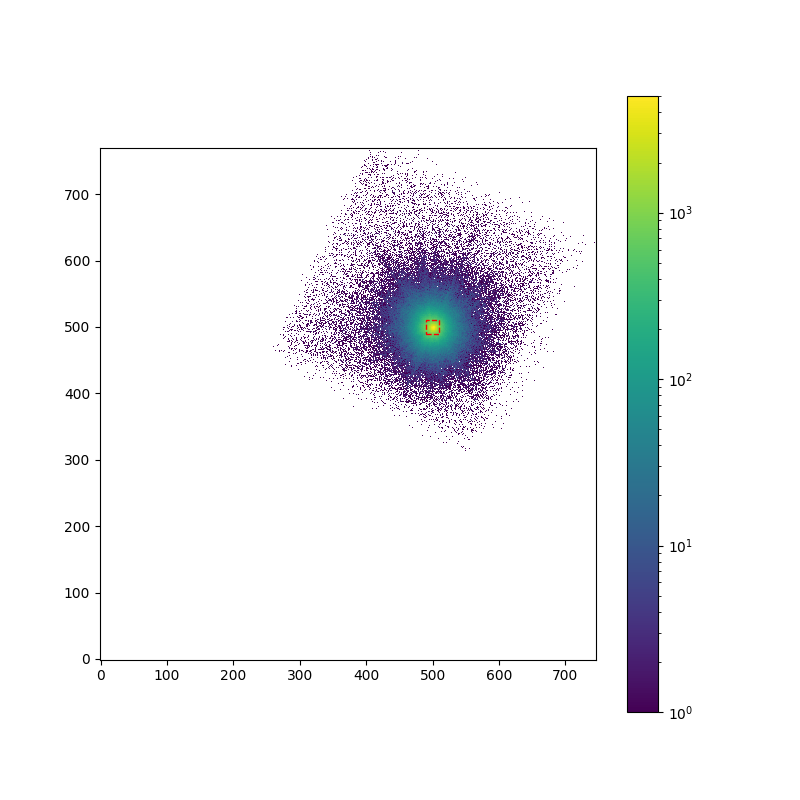

In [36]:
fig, ax = plt.subplots(figsize=(8,8))


# plt.xlim(450, 550)
# plt.ylimx(450, 550)
# ax.hist2d(x,y,(np.max(x)-np.min(x),np.max(y)-np.min(y)))
h = ax.hist2d(x,y,(np.max(x)-np.min(x),np.max(y)-np.min(y)), norm=mpl.colors.LogNorm())
rect = mpl.patches.Rectangle((490, 490), 20, 20, linewidth=1.0, edgecolor='r', facecolor='none', linestyle='--')
# Add the patch to the Axes
ax.add_patch(rect)
ax.set_aspect('equal', 'box')
fig.colorbar(h[3], ax=ax)

plt.show()

In [37]:
xy_filter = np.where((x>=490)*(x<=510)*(y>=490)*(y<=510))
# x, y, t = x[xy_filter], y[xy_filter], t[xy_filter]
t = t[xy_filter]

In [38]:
t.shape

(638300,)

In [39]:
lc = Lightcurve.make_lightcurve(t, dt=0.25)

<IPython.core.display.Javascript object>


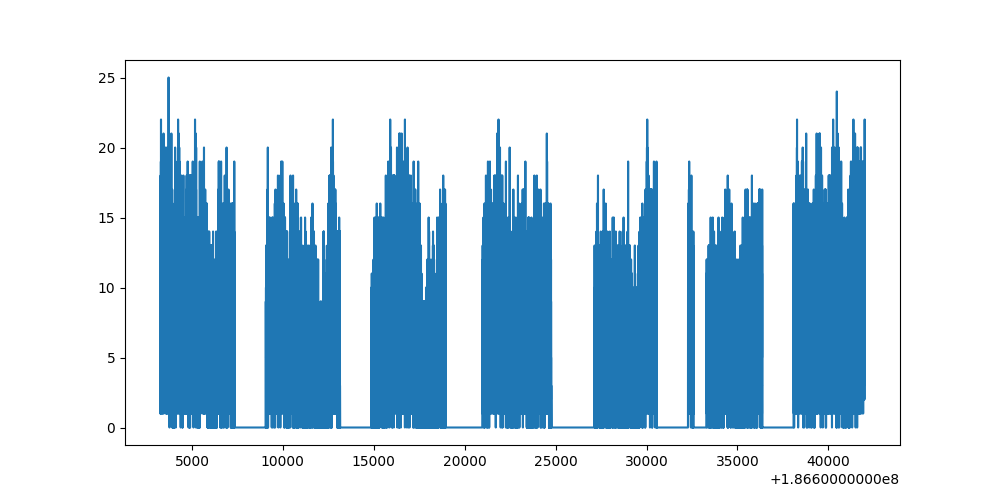

In [75]:
plt.figure(figsize=(10,5))
plt.step(lc.time, lc.counts)
plt.show()

In [41]:
times = t[t<7000+1.866e8]
len(times)

100705

In [45]:
periods = np.linspace(3, 7, 1000)
ef = np.zeros(1000)
nbins = 20
for i, per in enumerate(periods):
    if i%100==0:
        print(i)
    phase = times%per/per
    np.histogram(phase, bins=20)[0]
    observed = np.histogram(phase, bins=nbins)[0]
    expected = len(times)/nbins
    ef[i] = np.sum((observed-expected)**2/(expected**2))

0
100
200
300
400
500
600
700
800
900


<IPython.core.display.Javascript object>


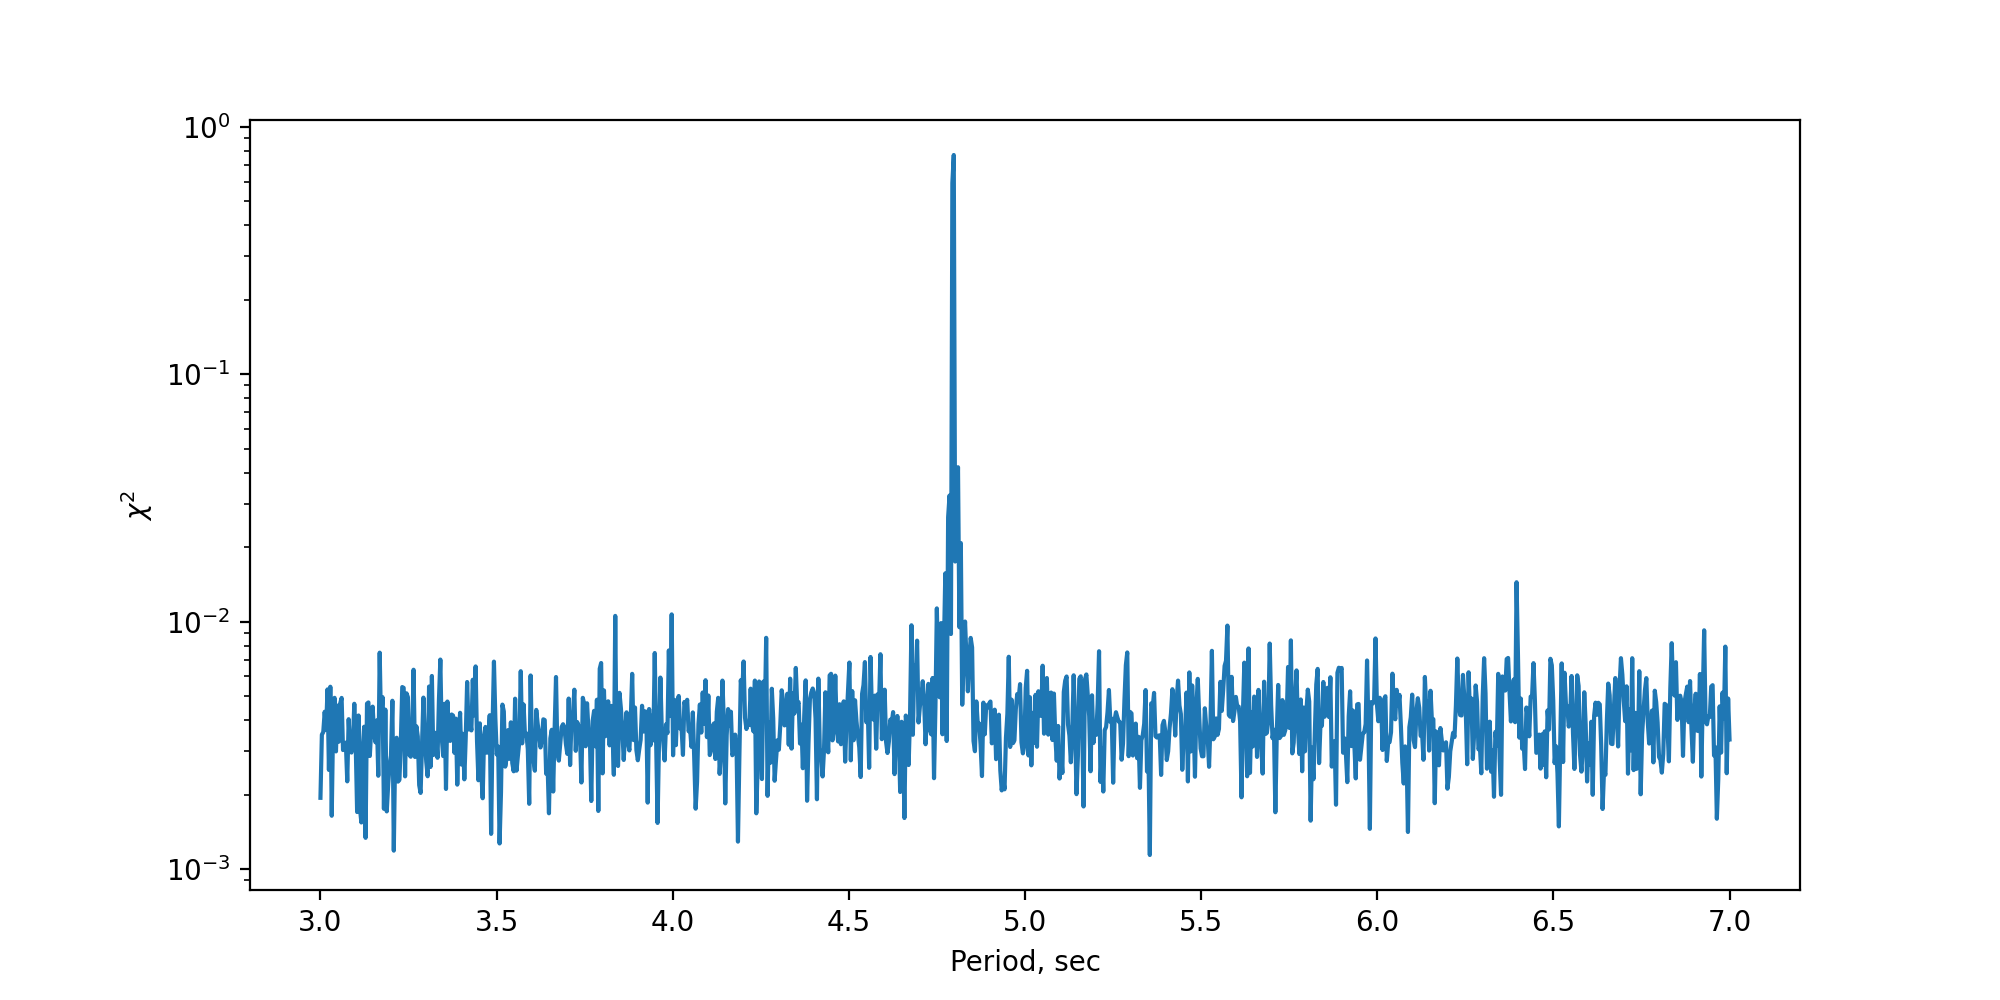

In [89]:
plt.figure(figsize=(10,5))
plt.plot(periods, ef)
plt.xlabel("Period, sec")
plt.ylabel(r"$\chi^2$")
plt.yscale('log')
plt.show()

In [53]:
found_period = periods[np.argmax(ef)]
found_period = 2*found_period
expected = len(times)/nbins

<IPython.core.display.Javascript object>


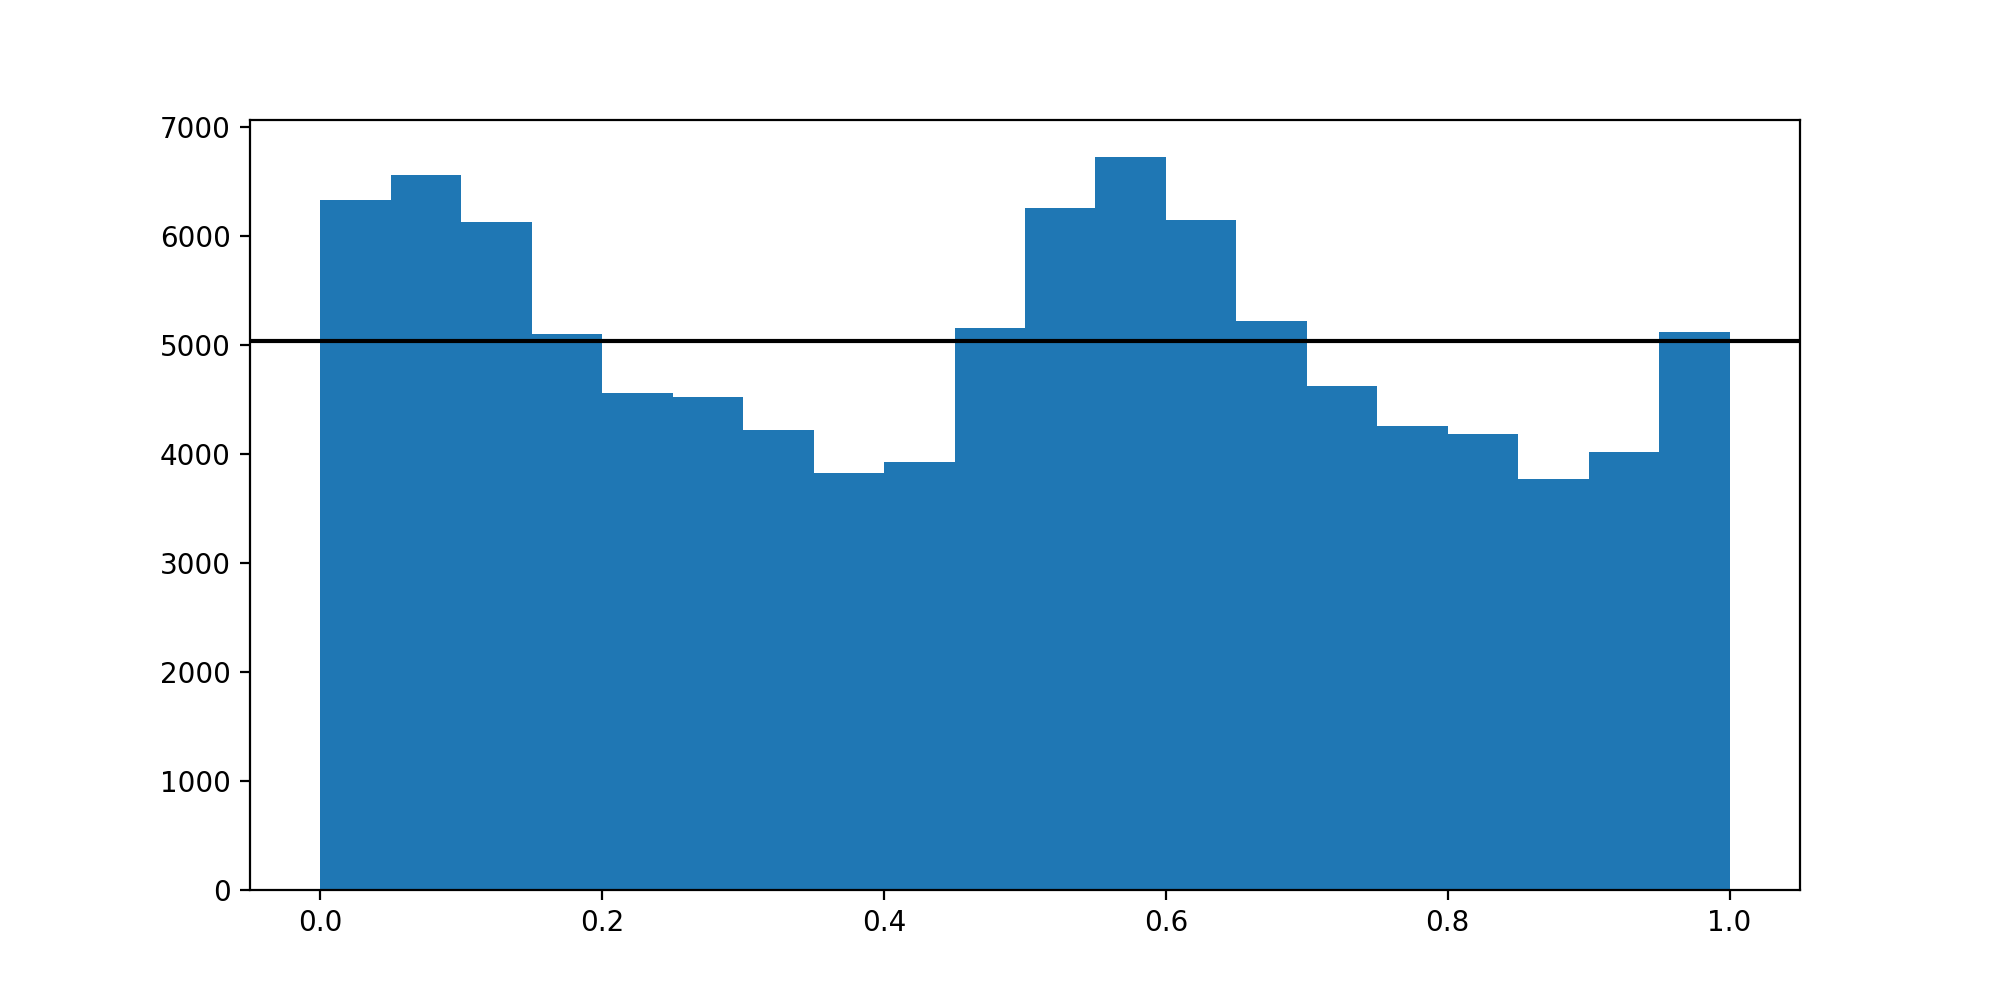

In [82]:
plt.figure(figsize=(10,5))
hi = plt.hist(times%found_period/found_period, bins=20)
plt.axhline(expected, color='k')
plt.show()

In [55]:
class EventGenerator:
    def __init__(self, rate, start_time, stop_time, gti=None, periodic=None):
        arrival_times = []
        _t = start_time - (1/rate)*np.log(1-np.random.random())
        while _t < stop_time:
            arrival_times.append(_t)
            _t -= (1/rate)*np.log(1-np.random.random())
        self.times = np.array(arrival_times)
        

In [57]:
np.min(times)

186603256.01156792

In [59]:
start_time = np.min(times)
stop_time = 7000+1.866e8
duration = stop_time- start_time
rate = len(times)/duration

In [68]:
simulations = [EventGenerator(rate, start_time, stop_time).times for i in range(10)]

In [63]:
lc_simulated = Lightcurve.make_lightcurve(simulations, dt=0.25)

<IPython.core.display.Javascript object>


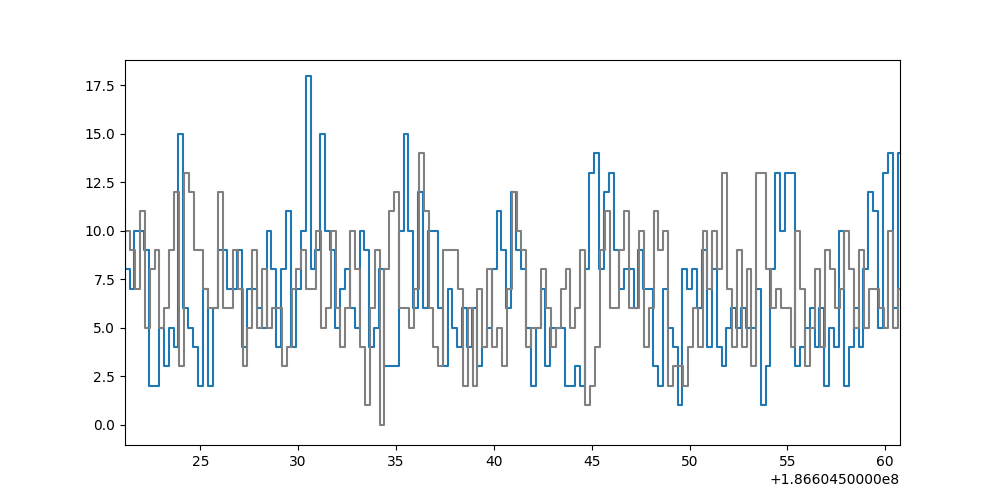

In [64]:
plt.figure(figsize=(10,5))
plt.step(lc.time, lc.counts)
plt.step(lc_simulated.time, lc_simulated.counts, color='gray')
plt.show()

In [70]:
periods = np.linspace(3, 7, 1000)
ef_simulated = np.zeros((10, 1000))
nbins = 20
for k in range(10):
    print(k)
    for i, per in enumerate(periods):
#         if i%100==0:
#             print(i)
        phase = simulations[k]%per/per
        np.histogram(phase, bins=20)[0]
        observed = np.histogram(phase, bins=nbins)[0]
        expected = len(times)/nbins
        ef_simulated[k][i] = np.sum((observed-expected)**2/(expected**2))

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


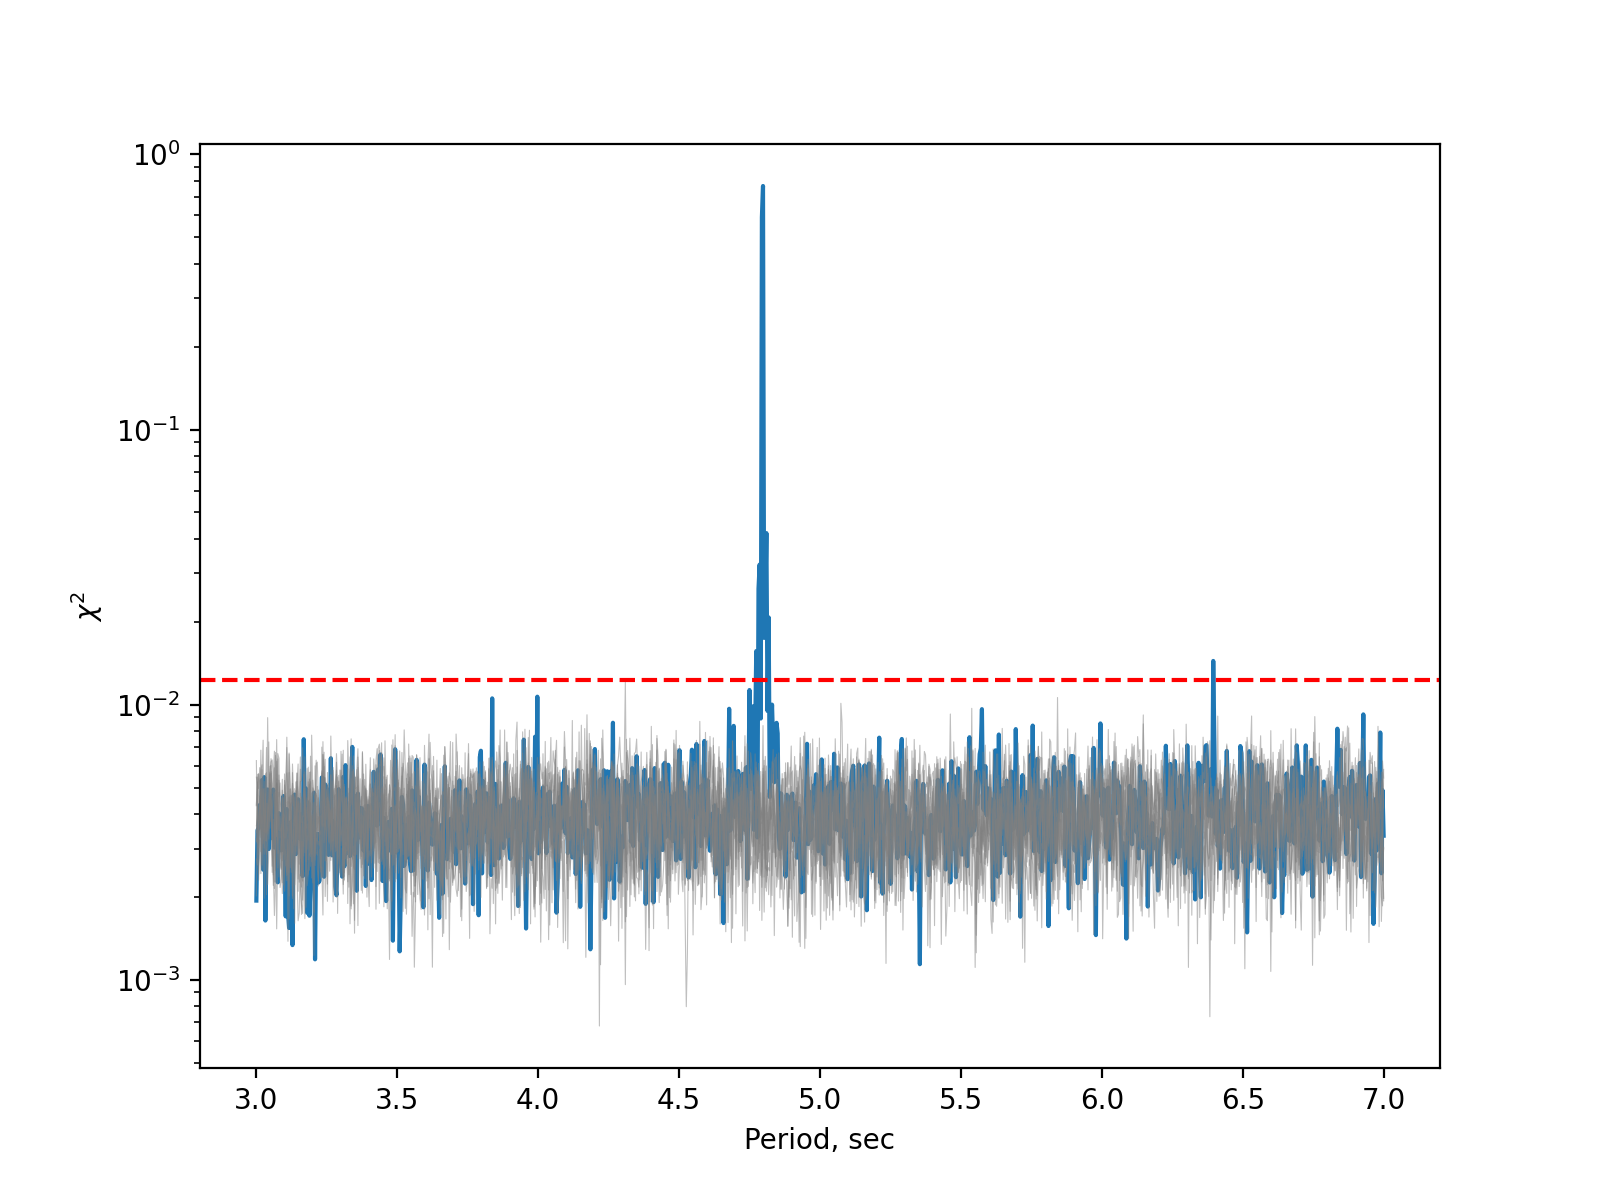

In [121]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(periods, ef)
for i in range(10):
    ax.plot(periods, ef_simulated[i], color='gray', alpha=0.5, lw=0.4)
ax.set_xlabel("Period, sec")
ax.set_ylabel(r"$\chi^2$")
ax.axhline(np.max(ef_simulated), color='red', linestyle='--')
ax.set_yscale('log')
plt.show()

<IPython.core.display.Javascript object>


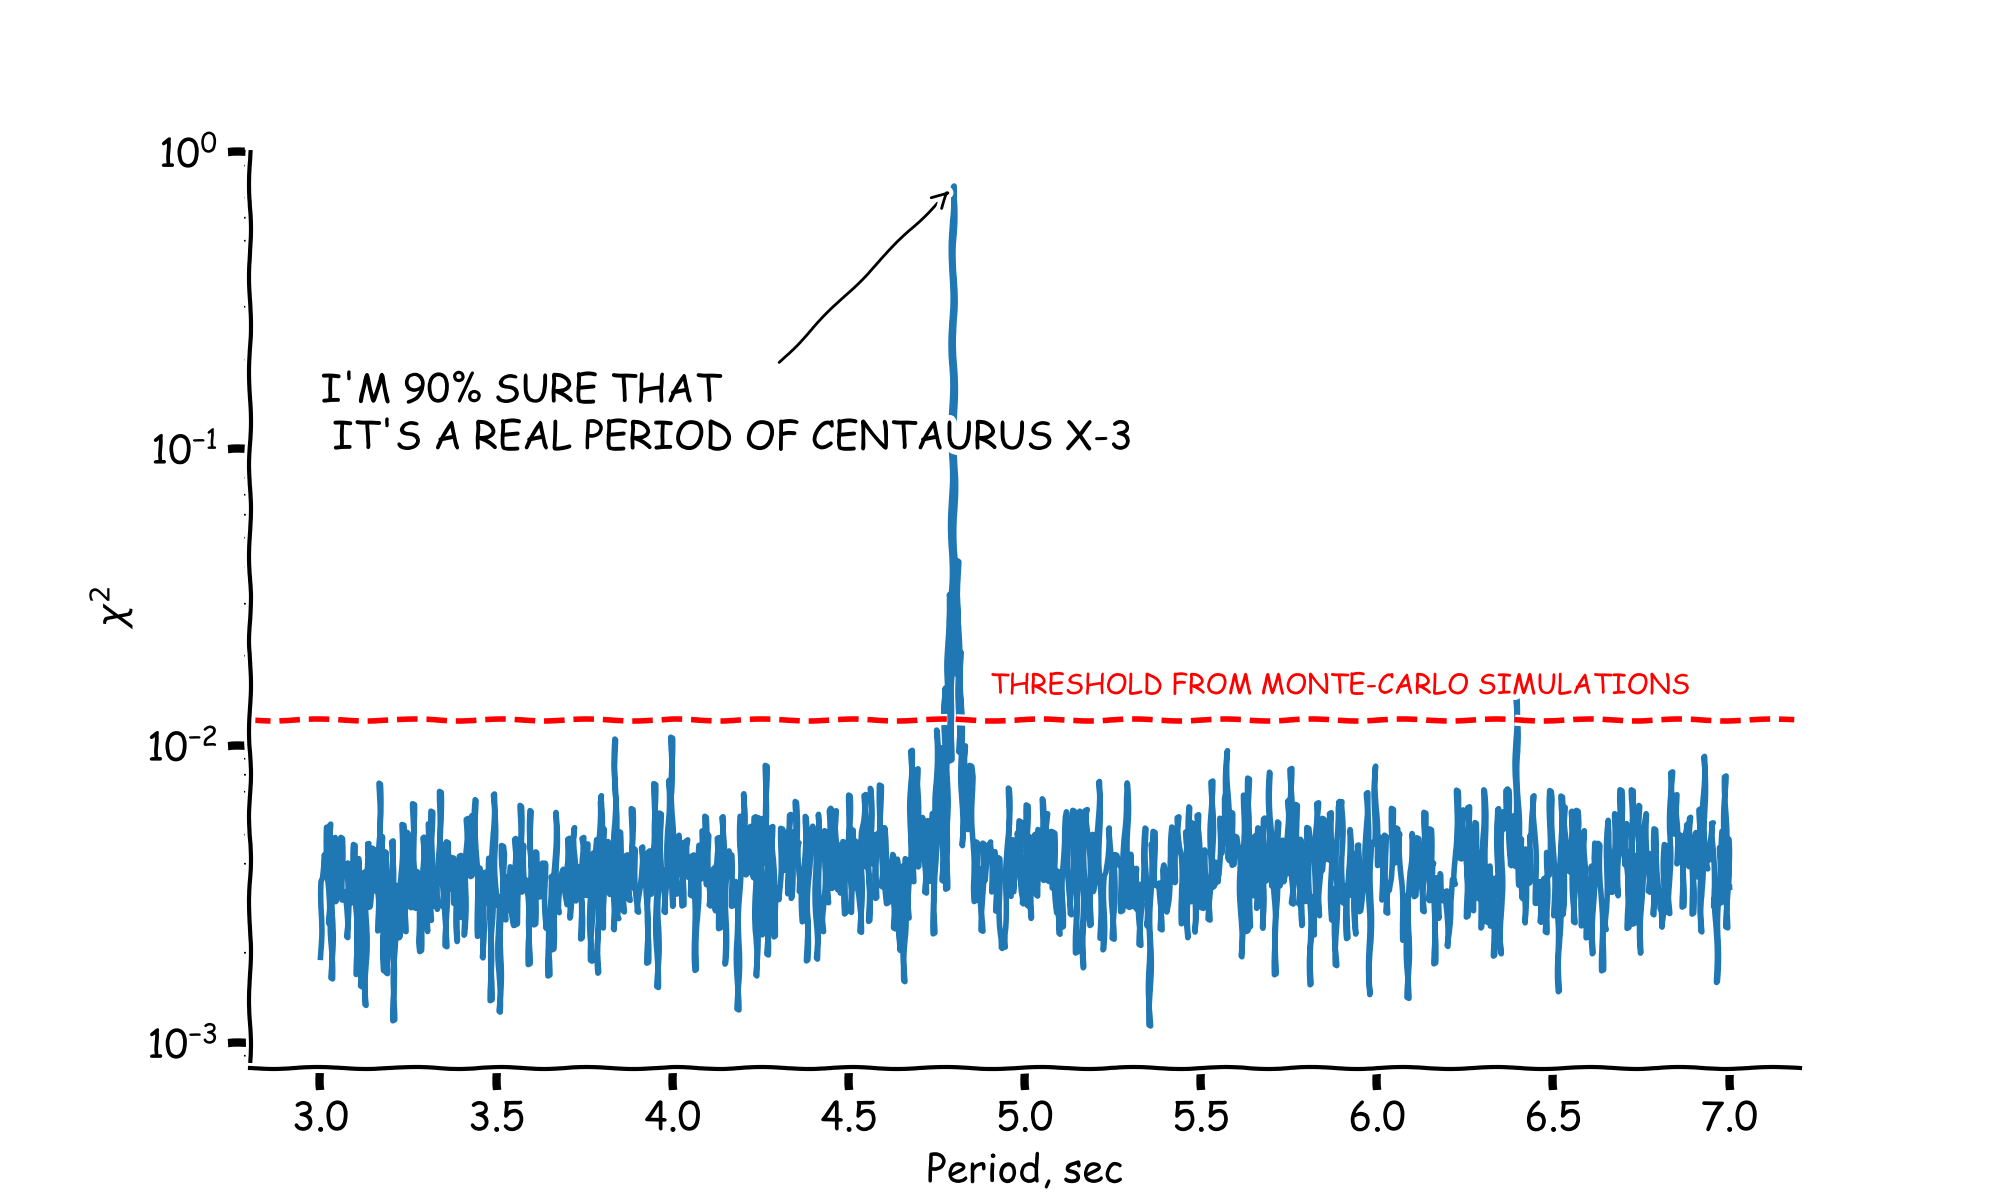

In [122]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(periods, ef)
    ax.text(4.9, 0.015, 'THRESHOLD FROM MONTE-CARLO SIMULATIONS', color='red', fontsize=10)
    ax.annotate(
        "I'M 90% SURE THAT \n IT'S A REAL PERIOD OF CENTAURUS X-3",
        xy=(periods[np.argmax(ef)], np.max(ef)), arrowprops=dict(arrowstyle='->'), xytext=(3.0, 0.10))
    ax.spines.right.set_color('none')
    ax.spines.top.set_color('none')
    
    ax.set_xlabel("Period, sec")
    ax.set_ylabel(r"$\chi^2$")
    ax.axhline(np.max(ef_simulated), color='red', linestyle='--')
    ax.set_yscale('log')
    plt.show()